Kaggle Competition: Wikipedia Traffic Time Series
-------------------------------------------------

In this notebook we'll have a look at the [Wikipedia Traffic Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting). The goal is to forecast the amount of traffic to various Wikipedia pages.

Let's start by having a look at the data.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet

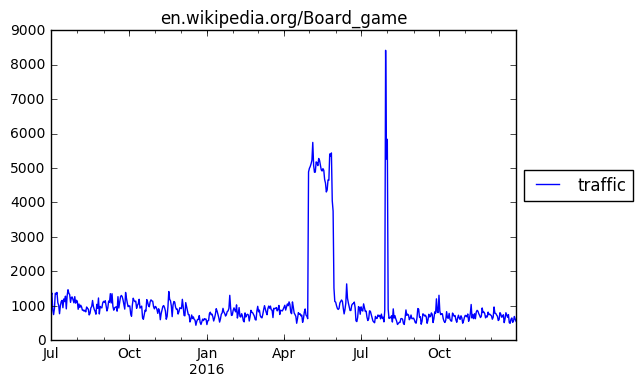

In [3]:
# Load in the training data
data = pd.read_csv('input/train_1.csv', header = 0, skiprows = range(1,11072), nrows = 1, index_col = 0).T

# Gather the metadata

# The metadata is in the column name of the transposed dataframe
meta_string = data.columns.values[0]

# The components are separated by underscores
meta_split = meta_string.split('_')

# We'll store the metadata in a dictionary
metadata = {}

# The article names can also contain underscores, on which we
# didn't actually want to split, so we have to check that we
# really got four pieces of data
if len(meta_split) > 4:
    # If not, we need to reconstruct the article name from the
    # split elements, all but the last three
    article_name_split = meta_split[:len(meta_split) - 3]
    metadata['article_name'] = "_".join(article_name_split)
else:
    # Otherwise, it's just the first element in the split
    metadata['article_name'] = meta_split[0]

# The other pieces of metadata we get by counting from the end
# of the split
metadata['domain'] = meta_split[len(meta_split) - 3]
metadata['access'] = meta_split[len(meta_split) - 2]
metadata['agent'] = meta_split[len(meta_split) - 1]

# Rename the column to "traffic" instead of the metadata string
data.columns = ['traffic']

# Convert the index to a datetime
data.index = pd.to_datetime(data.index)

# Visualize the data
data.plot(title = metadata['domain'] + "/" + metadata['article_name']).legend(loc='center left', bbox_to_anchor=(1, 0.5));

Above, we've loaded up the time series for one specific page, extracted the metadata, prepared the data a little, and finally plotted the series. The traffic for this page is quite steady, perhaps slightly decreasing over time, with two large peaks. One is a month-long peak in May, the latter a short peak of a few days in August.

The question is what such peaks mean. Should we expect another peak in the summer of 2017, or was this a one-off event? Unfortunately we don't have a long enough window of time to be sure. So what can we do?

A very simply model
-------------------

The competition requires us to forecast a fairly short period of time: the next two months after the period for which the data is provided. On that time scale, questions about trends on the scale of seasons and beyond may not be very relevant. Therefore, let's try something simple: we just assume that the time series will continue as it has in the recent past. We'll take the median value of the last month or so, and just use that single value as our forecast. Let's split our data into a training and test set and see how it goes.

In [4]:
# Training and test sets
ntrain = int((3/4)*len(data))
data_train = data.iloc[:ntrain]
data_test = data.iloc[ntrain:]

To score our prediction, the competition uses [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error), so we'll implement a function to calculate it, as well as some functions to make our predictions.

In [29]:
"""
Implement the SMAPE score
"""
def SMAPE(truth, prediction):
    numerator = np.abs(truth - prediction)
    denominator = np.abs(truth) + np.abs(prediction)
    return 200*np.mean(numerator/denominator)

"""
Calculate the median of a time series over a period at the end
of that series.
"""
def past_median(series, days):
    return series.iloc[-days:].median().values[0]

"""
Make a past-median-based prediction.
"""
def predict(train, test, median_days):
    train_median = past_median(train, median_days)
    test_predict = test.copy()
    test_predict['traffic'] = train_median
    return test_predict

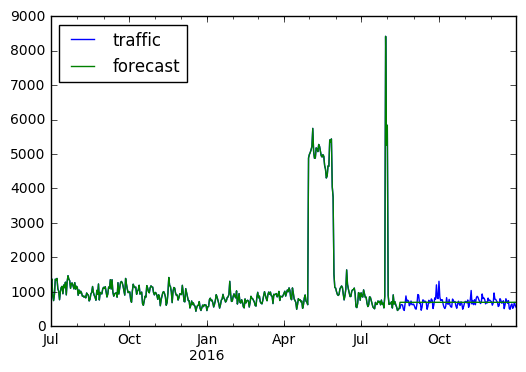

In [9]:
# Create a forecast based on our training set
forecast = pd.concat([data_train, predict(data_train, data_test, 50)])

# Dataframe containing both the real data and our forecast for plotting
combined = data.copy()
combined['forecast']  = forecast['traffic']

combined.plot();

Above we made a prediction using a 50-day median and plotted the result. The constant value of course doesn't capture the variations in the data, but besides that it seems like a reasonable prediction. Our SMAPE score is not bad:

In [8]:
SMAPE(predict(data_train, data_test, 50).values, data_test.values)

13.852541979165048

Performing this same analysis on a random sample (see `forecast_median.py`) of 1200 pages from the data set (about 1% of the set), we find an average SMAPE score of 52.48, which is similar to the scores currently on the leaderboard. Can we do any better?

A more elaborate Prophecy
-------------------------

Let's try something a little fancier. We'll use [Facebook's Prophet](https://facebookincubator.github.io/prophet/) package to do our forecasting. It's a package specifically designed for forecasting based on time series, and includes support for linear trends, capped growth and, through Fourier series, periodicity or seasonality. Can this approach help us out?

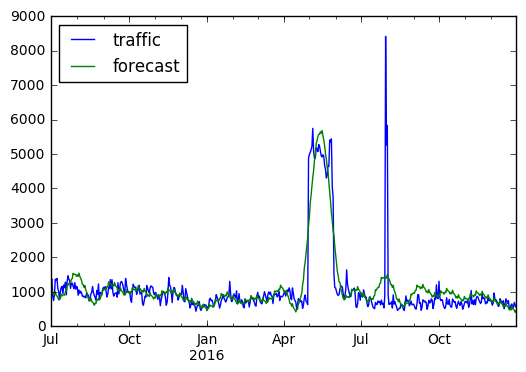

In [23]:
# Setting up a training dataframe for Prophet
prophet_train = pd.DataFrame(index = range(len(data_train)))
prophet_train['ds'] = data_train.index.copy()
prophet_train['y'] = data_train['traffic'].values

# Fitting the model. We'll use yearly seasonality for this set.
model = Prophet(yearly_seasonality = True)
model.fit(prophet_train)

# Generate prediction
future = model.make_future_dataframe(periods = len(data)-ntrain)
forecast = model.predict(future)
forecast.index = forecast['ds']
# Dataframe containing both the real data and our forecast for plotting
combined = data.copy()
combined['forecast']  = forecast['yhat']
combined.plot();

Above, we fitted a Prophet model to our time series. As a fit, it does a decent job, recognizing some of the oscillatory behavior and peaks in the signal. However, as a forecast, for the last quarter of the series, it doesn't look so good. It's overshooting the true values, and we don't find a great score:

In [24]:
SMAPE(forecast['yhat'].iloc[-ntrain:].values, data_test.values)

39.148372106019352

What seems to be happening is that the model is overfitting the data for our purposes. If the big peak in summer is a real seasonal event, this fit is great: it will predict the same peak next year. However, if the features in the data are mostly random, or one-off events, fitting our model to them doesn't help. At least for our current purpose of short-range forecasting, we're not doing any better.

Perhaps we can improve the results by smoothing out the results a bit. Especially mitigating large outliers may help.

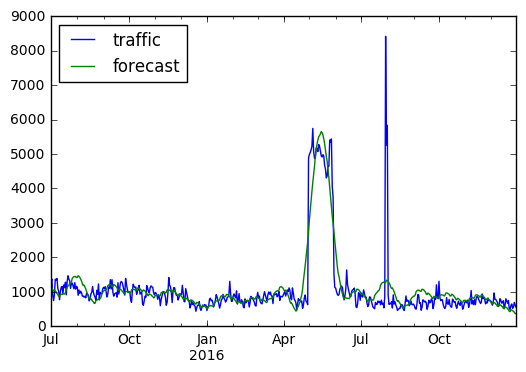

In [26]:
# Set up a new dataframe
prophet_train_filtered = pd.DataFrame(index = range(len(data_train)))
prophet_train_filtered['ds'] = data_train.index.copy()

# Apply a rolling median filter to the data
prophet_train_filtered['y'] = prophet_train['y'].rolling(window = 4, min_periods = 1, center = True).median()

# Fit a model
model = Prophet(yearly_seasonality = True)
model.fit(prophet_train_filtered)

# Predict
future = model.make_future_dataframe(periods = len(data)-ntrain)
forecast_filtered = model.predict(future)
forecast_filtered.index = forecast_filtered['ds']

# Dataframe containing both the real data and our forecast for plotting
combined = data.copy()
combined['forecast']  = forecast_filtered['yhat']
combined.plot();

In [27]:
SMAPE(forecast_filtered['yhat'].iloc[-ntrain:].values, data_test.values)

37.389127378173001

The smoothing indeed improves the score, but not substantially. We are still not close to the score of our median result, which is essentially just a very aggressive smoothing.

We have only seen a single dataset, but unfortunately we do not fare better in general. Let's consider the sample from before. For each dataset, filtering may or may not improve things, so we will try both. Additionally, we will turn the yearly seasonality on or off, since the forecasts may or may not benefit from including such long-term trends. Thus in total, we will fit four models to each dataset; see `forecast_seasonality_filtering.py` and the `bash` scripts that call it.

Choosing for every page the optimal of these four models, we still obtain a score of 64.48; hardly impressive.


Back to a simple model, just slightly less
------------------------------------------

We see that Facebook's Prophet package is not really helping us out here. The features it is fitting to do not seem to be very relevant. This is perhaps just because the periods of the seasonality that it considers are too long-term. We simply don't have a big enough time window to properly fit yearly periodic fluctuations or events.

But that doesn't mean that no periodicity exists. Perhaps looking at more short-term fluctuations would help. For now, let's go for a simple proof of concept. We go back to our past-median model, but we add a slight bit of nuance: we separate weekdays from weekends. Many pages on Wikipedia probably get more traffic on weekends, when people have time to look stuff up. On the other hand, some pages may be useful to people at work, and receive more traffic during the week. Either way, what we can do is calculate our past mean separately for weekdays and weekends, and forecast accordingly.

In [28]:
# Add a boolean it's-a-weekday column
data['weekday'] = data.index.weekday < 5

# Rebuild the training and test sets
ntrain = int((3/4)*len(data))
data_train = data.iloc[:ntrain]
data_test = data.iloc[ntrain:]

# We now have additional information
data.head()

,traffic,weekday
2015-07-01,1287,True
2015-07-02,1370,True
2015-07-03,887,True
2015-07-04,745,False
2015-07-05,925,False


We now have an additional feature that tells us whether a data point corresponds to a weekday or not. Let's predict based on these two different groups.

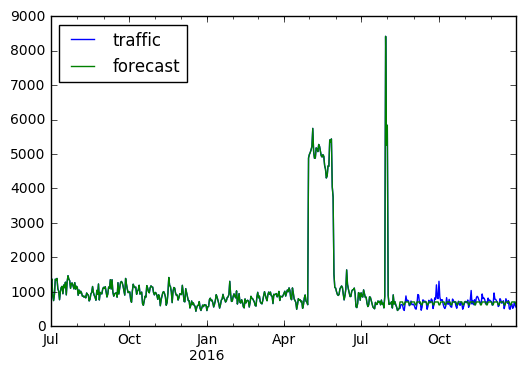

In [31]:
"""
Calculate the median over the past so many days, but only
taking into account the weekdays.
"""
def past_median_weekday(data, days):
    past_data = data.iloc[-days:]
    return past_data[past_data['weekday']].median().values[0]

"""
Calculate the median over the past so many days, but only
taking into account the weekends.
"""
def past_median_weekend(data, days):
    past_data = data.iloc[-days:]
    return past_data[~past_data['weekday']].median().values[0]

"""
Generate a prediction with separate values for weekdays
and weekends.
"""
def predict_weekday_based(train, test, median_days):
    weekday_median = past_median_weekday(train, median_days)
    weekend_median = past_median_weekend(train, median_days)
    test_predict = test.copy()
    test_predict.loc[test_predict['weekday'].values, 'traffic'] = weekday_median
    test_predict.loc[~test_predict['weekday'].values, 'traffic'] = weekend_median
    return test_predict


# Create a forecast based on our training set
forecast = pd.concat([data_train, predict_weekday_based(data_train, data_test, 50)])

# Dataframe containing both the real data and our forecast for plotting
combined = data.copy()
combined['forecast']  = forecast['traffic']

combined[['traffic', 'forecast']].plot();

The difference is not huge, but the weekend effect does seem to be real: our SMAPE score has improved. On the 1200-page sample, the average score is down slightly to 52.36.

This was finally the technique I used to generate a full submission. It scored 45.2 on the first-round test data, which, at time of writing, is about halfway up the leaderboard.

In [32]:
SMAPE(predict_weekday_based(data_train, data_test, 50)['traffic'].values, data_test['traffic'].values)

11.779228833580836